# Data preparation

In this notebook we regroup all the results about the illustrations into a single dataframe.
We then clean the data to homogenize it to be able to use it easily.

## Merging infos

In [21]:
# Some imports
import pandas as pd
from deep_translator import GoogleTranslator
import math
import regex as re
import glob
import shutil
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import numpy as np

We merge information from painting reproductions from Smartify (`illu_infos_clean`), Artnet (`artnet_data`), Wikimedia commons (`commons_data`) and the Orsay museum (`orsay_data`).

In [231]:
# Smartify data
known_paintings_df = pd.read_csv("./data/illu_infos_clean.csv")
known_paintings_df = known_paintings_df.set_index('id')

In [232]:
# Adding Artnet data
artnet = pd.read_csv("./data/artnet_data.csv")
artnet.columns = map(str.lower, artnet.columns)
artnet = artnet.set_index('id')
all_illus = known_paintings_df.append(artnet)

In [233]:
# Adding Wikimedia Commons data
commons = pd.read_csv("./data/commons_data.csv")
commons.columns = map(str.lower, commons.columns)
commons = commons.set_index('id')
all_illus = all_illus.append(commons)

In [234]:
# Adding Orsay data
orsay = pd.read_csv("./data/orsay_data.csv")
orsay.columns = map(str.lower, orsay.columns)
orsay = orsay.set_index('id')
all_illus = all_illus.append(orsay)

Because all the data that we are stacking is known to be painting reproductions (by construction), we add a column "Category" in which they all belong to "Reroduction".

In [235]:
all_illus['category'] = all_illus.apply(lambda row: "Reproduction", axis=1)

And finally we can add our knowledge of the illustrations' categories.

In [237]:
cats = pd.read_csv("./data/final_pred_cat.csv")
cats = cats.set_index('id')
cats = cats.rename(columns={'pred_cat': 'category'})

In [238]:
df = all_illus.append(cats)

We drop illustrations which are twice in de dataframe. By default, the first occurence is kept.

In [239]:
df = df[~df.index.duplicated()]

In [240]:
# Cleaning data illustrations names
df.index = df.index.str.replace(" \(1\)", "").str.replace("\(1\)", "")

C:\Users\emichelet\AppData\Local\Temp\ipykernel_6640\3837249030.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df.index = df.index.str.replace(" \(1\)", "").str.replace("\(1\)", "")


We also enrich the metadata of the illustrations by adding the ID of the journal it comes from.

In [53]:
master = pd.read_csv('data/DFKV_Master.csv')
master

,ID,Volume_ID,_journal-id,liens iiif,liens de citation (page),liens de citation (volume),bibliographie
0,15573,8640,1411.0,NaN,NaN,https://gallica.bnf.fr/ark:/12148/bpt6k7522165...,supplément
1,14385,8640,1518.0,NaN,x,NaN,NaN
2,14389,8641,1568.0,NaN,NaN,https://gallica.bnf.fr/ark:/12148/bpt6k360915?...,NaN
3,14390,8642,1568.0,NaN,NaN,https://gallica.bnf.fr/ark:/12148/bpt6k36087x?...,NaN
4,14394,8643,1568.0,https://gallica.bnf.fr/iiif/ark:/12148/bpt6k36...,https://gallica.bnf.fr/ark:/12148/bpt6k36008s/...,NaN,NaN
...,...,...,...,...,...,...,...
6323,14457,8636,1463.0,https://gallica.bnf.fr/iiif/ark:/12148/bpt6k57...,https://gallica.bnf.fr/ark:/12148/bpt6k5780528...,NaN,S. 121-136
6324,14458,8637,1463.0,https://gallica.bnf.fr/iiif/ark:/12148/bpt6k57...,https://gallica.bnf.fr/ark:/12148/bpt6k5780528...,NaN,S. 287-304 (dernier article)
6325,14924,8638,1491.0,https://gallica.bnf.fr/iiif/ark:/12148/bpt6k30...,https://gallica.bnf.fr/ark:/12148/bpt6k3047055...,NaN,"4e année, n° 60, 1.7.1919, p. 473-475"
6326,14922,8639,1491.0,https://gallica.bnf.fr/iiif/ark:/12148/bpt6k30...,https://gallica.bnf.fr/ark:/12148/bpt6k3047050...,NaN,"4e année, n° 55, 1.2.1919, p. 433-436"


In [287]:
df['journal_id'] = df.apply(lambda row: int(list(master[master['ID'] == int(row.name.split('_')[1])]["_journal-id"])[0]), axis=1)

And finally, we save our results.

In [292]:
df.to_csv('data/merged_data.csv', index=True)

## Cleaning

Now, let's go through all the columns and clean them, so that their content is easy to use.

In [397]:
df = pd.read_csv('data/merged_data.csv').set_index('id')
df.sample(5)

,title,author,link,technique,dimensions,date,category,journal_id
id,,,,,,,,
ILLU_11516_325_0,Still Life with Apples,Paul Cézanne,NaN,Oil on canvas,46 x 55cm,1894,Reproduction,1438
ILLU_15313_189_0,NaN,NaN,NaN,NaN,NaN,NaN,Ornament,1476
ILLU_16302_332_2,NaN,NaN,NaN,NaN,NaN,NaN,Reproduction,1302
ILLU_14960_64_2,NaN,NaN,NaN,NaN,NaN,NaN,Reproduction,1473
ILLU_15305_21_0,NaN,NaN,NaN,NaN,NaN,NaN,Reproduction,1476


### Technique

For the 'technique' column, we will homogenize them by putting everything in lowercase, and translating everything back to english.

In [398]:
# translate
df['technique'] = df.apply(lambda row: GoogleTranslator(source='auto', target='en').translate(row['technique'])
                           if row['technique'] == row['technique']
                           else row['technique'], axis=1)

In [399]:
# lowercase everything
df['technique'] = df['technique'].str.lower()

In [400]:
# a look at the most popular techniques
df.groupby('technique').count().sort_values('category', ascending=False).head()

,title,author,link,dimensions,date,category,journal_id
technique,,,,,,,
oil on canvas,1034,1066,610,933,1033,1066,1066
oil on panel,39,39,27,31,36,39,39
oil,10,18,1,11,16,18,18
ink on paper,16,16,0,7,16,16,16
pastel,14,14,0,6,12,14,14


### Dimensions

The dimensions are more challenging, as the format used is very different from one row to another. We will : remove everything that's between parentheses, because usually it contains the conversion in inches. We also remove white spaces, unnecessary words ("Height:"), and put everything in centimeters and the same format : HxWcm

In [419]:
def clean_height_width(dimensions):
    if dimensions == dimensions: #Will be false if NaN
        if ('height' in dimensions and 'width' in dimensions) or ('H.' in dimensions and 'L.' in dimensions):
            hw = re.findall(r"[-+]?(?:\d*\.\d+|\d+)", dimensions)
            return hw[0] + 'x' + dimensions[dimensions.find(hw[1]) : dimensions.find(hw[1]) + len(hw[1]) + 2]
        elif 'height' in dimensions:
            h = re.findall(r"[-+]?(?:\d*\.\d+|\d+)", dimensions)[0]
            idx = dimensions.find(h)
            return dimensions[idx : idx + len(h) + 2]
        else:
            return dimensions
    else:
        return dimensions

To convert everything in centimeters, we need to be careful about the current metric, it could be from meters to millimeters, or even in inches !

In [488]:
def convert_in_cm(dimensions):
    if dimensions == dimensions:
        metric = re.findall("[a-zA-Z]+",  dimensions)[-1] # the letters are the metric
        values = re.findall(r"[-+]?(?:\d*\.\d+|\d+)",  dimensions) # the numbers are the value
        coeff = 2.54 if metric == "in" else 10 if metric == "m" else .1 if metric == "mm" else 1 # choose appropriate coefficient
        return "x".join([format(float(v) * coeff, '.2f') for v in values]) + "cm"
    else:
        return dimensions

In [490]:
# remove what's between parenthesis
df['dimensions'] = df['dimensions'].str.replace(r"\(.*\)","")
# remove white spaces
df['dimensions'] = df['dimensions'].str.replace(" ", "")
# deal with commas instead of points
df['dimensions'] = df['dimensions'].str.replace(",", ".")
# deal with :  \nheight: 47 cm (18.5 in) ; width: 38.4 cm 
df['dimensions'] = df.apply(lambda row: clean_height_width(row["dimensions"]), axis=1)
# conversion in cm
df['dimensions'] = df.apply(lambda row: convert_in_cm(row["dimensions"]), axis=1)
df.sample(10)

C:\Users\emichelet\AppData\Local\Temp\ipykernel_6640\1544484082.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['dimensions'] = df['dimensions'].str.replace(r"\(.*\)","")


,title,author,link,technique,dimensions,date,category,journal_id
id,,,,,,,,
ILLU_10467_498_0,Still Life with Herrings,Jean-Siméon Chardin,https://clevelandart.org/art/1974.1,oil on canvas,41.00x33.60cm,c. 1735,Reproduction,1438
ILLU_12372_379_1,NaN,NaN,NaN,NaN,NaN,NaN,Reproduction,1438
ILLU_12659_45_0,NaN,NaN,NaN,NaN,NaN,NaN,Reproduction,1336
ILLU_15409_360_1,NaN,NaN,NaN,NaN,NaN,NaN,Sculpture,1600
ILLU_12003_24256_2,NaN,NaN,NaN,NaN,NaN,NaN,Architecture_decoration,1384
ILLU_11309_37_0,Le pont de Mantes (environs de Paris),Camille Corot,https://donate.louvre.fr/particuliers/~mon-don,oil on canvas,3.80x5.50cm,Vers 1868 - 1870,Reproduction,1438
ILLU_10556_280_0,NaN,NaN,NaN,NaN,NaN,NaN,Reproduction,1368
ILLU_10535_169_0,NaN,NaN,NaN,NaN,NaN,NaN,Reproduction,1368
ILLU_10875_308_0,NaN,NaN,NaN,NaN,NaN,NaN,Sculpture,1438


### Date

Finally we create an additional column that will be used to sort chronologically the illustrations, thus we have to simplify to only keep one year. Example : "c. 1978" -> "1978"; "Between 1883 and 1990" -> "1883", ...

In [537]:
def simplify_date(date):
    if date == date:
        dates = re.findall('[0-9]+', date)
        if len(dates)>0:
            return dates[0]
        else:
            return float('NaN')
    else:
        return date

In [538]:
df['date_s'] = df.apply(lambda row: simplify_date(row["date"]), axis=1)

In [548]:
df.sample(5)

,title,author,link,technique,dimensions,date,category,journal_id,date_s
id,,,,,,,,,
ILLU_14377_346_2,Seated and Standing Woman,Georges Seurat,NaN,oil on wood,NaN,1884,Reproduction,1302,1884
ILLU_14279_124_0,After the Luncheon,Pierre-Auguste Renoir,https://commons.wikimedia.org/wiki/File:August...,oil on canvas,81.30x100.50cm,1879,Reproduction,1408,1879
ILLU_14957_195_5,NaN,NaN,NaN,NaN,NaN,NaN,Reproduction,1473,NaN
ILLU_15361_89_0,NaN,NaN,NaN,NaN,NaN,NaN,Reproduction,1279,NaN
ILLU_14405_40_1,NaN,NaN,NaN,NaN,NaN,NaN,Sculpture,1302,NaN


And we save the clean and complete dataframe.

In [549]:
df.to_csv("data/full_data_clean.csv")

## Prepare painting data for Vikus Viewer test

For our next visualisation, we need data in a special format. Every column except the ID, the keywords and the year must bust preceeded by an underscore. We start with a basic subset of columns, for a test visualisation. We also do this on a subset of data, only on the reproductions that have metadata about them.

In [77]:
data_complet = pd.read_excel("./data/DFKV_Data_complet.xlsx", sheet_name="Data_complet")

In [95]:
df = pd.read_csv("data/full_data_clean.csv")
df = df.dropna(subset=['date_s'])
df = df.rename(columns={"date_s": "_date-artwork"})
df['year'] = df.apply(lambda row: list(data_complet[data_complet['id'] == int(row["id"].split('_')[1])]["date"])[0].split('-')[0], axis=1)
df['keywords'] = df['category']

In [96]:
df = df.rename(columns={"title":"_descrpiton", "technique": "_material", "dimensions": "_dimensions", "author":"_artist"})

In [97]:
df = df.drop(columns=['link', 'date', 'category', 'journal_id'])

In [98]:
df.to_csv("data/simple_dfkv_vikus.csv", index=False)

In [99]:
df

,id,_descrpiton,_artist,_material,_dimensions,_date-artwork,year,keywords
0,ILLU_10332_143_0,Girl and Cat,Auguste Renoir,oil on canvas,NaN,1882.0,1910,Reproduction
1,ILLU_10346_257_0,The death of Laras,Eugène Delacroix,oil on canvas,62.00x50.00cm,1858.0,1912,Reproduction
2,ILLU_10359_147_0,Une Baignade à Asnières,Georges Seurat,oil on canvas,201.00x300.00cm,1884.0,1932,Reproduction
3,ILLU_10362_309_0,Landscape,André Derain,oil on canvas,60.00x73.00cm,1930.0,1932,Reproduction
4,ILLU_10365_17_0,Figure at the Rideau Releve,Henri Matisse,oil on canvas,NaN,1923.0,1929,Reproduction
...,...,...,...,...,...,...,...,...
1739,ILLU_12014_482_0,Mademoiselle Dihau au piano,Edgar Degas,oil on canvas,0.40x0.50cm,1869.0,1937,Reproduction
1740,ILLU_13055_13_0,La Famille du peintre,Eugène Carrière,oil on canvas,0.12x0.50cm,1893.0,1906,Reproduction
1741,ILLU_13061_275_0,Le Bûcheron,Ferdinand Hodler,oil on canvas,0.13x0.50cm,1910.0,1910,Reproduction
1742,ILLU_13291_21_0,Siesta,Hans Thoma,oil on canvas,0.88x0.40cm,1889.0,1921,Reproduction


We will also load the images in a separate folder.

In [37]:
for illu in tqdm(df.id):
    src_path = "./DFKV/" + illu + ".jpg"
    dst_path = "../6_vikus_viewer/data/DFKV_subset/" + illu + ".jpg"
    shutil.copy(src_path, dst_path)

100%|██████████| 1642/1642 [02:29<00:00, 11.01it/s]


For the viewer, we also need a timeline, which is basically a dataframe with all the (sorted) dates that appear in our dataset

In [90]:
timeline = pd.DataFrame()
timeline["year"] = df["year"].unique()
timeline["year"] = timeline.apply(lambda row: row["year"].split('-')[0], axis=1) # If there is a time interval, only take the first one

In [91]:
timeline = timeline.sort_values(by="year")

In [92]:
timeline["titel"] = " "
timeline["text"] = " "

In [94]:
timeline.to_csv("data/timeline.csv")

## Prepare data for Vikus Viewer

And now we do it again, but on all the data, with all the columns that we want.

In [33]:
# Loading our files
df = pd.read_csv("data/full_data_clean.csv")
data_complet = pd.read_excel("./data/DFKV_Data_complet.xlsx", sheet_name="Data_complet")
link_df = pd.read_csv("./data/link_images.csv")
master_df = pd.read_csv("./data/DFKV_master.csv")
xls = pd.ExcelFile('./data/DFKV_master.xlsx')
journals_df = pd.read_excel(xls, 'Journal')

In [82]:
# Handy function to convert a string of a year into an integer
def convert_to_int(year):
    return int(year) if year == year else "NaN"  

In [ ]:
def modify_url_appropriate_page(data_id, page):
    # Change the page number
    # Exemple of urls :
    # https://digi.ub.uni-heidelberg.de/diglit/kk1905/0199
    # https://gallica.bnf.fr/ark:/12148/bpt6k97952378/canvas/f299
    # And convert
    link = master_df[master_df["ID"] == data_id].iloc[0]["liens de citation (page)"]
    if "gallica" in link:
        current_page = link.split("/")[-1]
        wanted_page = "f" + str(int(page) -  int(link_df[link_df["ID"] == data_id]["liens iiif"].iloc[0].split("/")[7].replace("f", "")) + int(current_page.split(".")[0].replace("f", "")))
        return link.replace(current_page, wanted_page)
    else:
        current_page = link.split("/")[-1]
        wanted_page = str(int(page)  - int(link_df[link_df["ID"] == data_id]["liens iiif"].iloc[0].split("/")[-1].replace(".jpg", "")) + int(current_page.split(".")[0]))
        return link.replace(current_page, wanted_page)

In [35]:
# Cleaning all the columns
df = df.rename(columns={"date_s": "_date-artwork"})
df['year'] = df.apply(lambda row: str(list(data_complet[data_complet['id'] == int(row["id"].split('_')[1])]["date"])[0]).split('-')[0], axis=1)
df['keywords'] = df['category']
df = df.rename(columns={"title":"_description", "technique": "_material", "dimensions": "_dimensions", "author":"_artist",
                       "link" : "_source", "journal_id": "_journal-id"})
df = df.drop(columns=['date', 'category'])
df["_date-artwork"] = df.apply(lambda row: convert_to_int(row["_date-artwork"]), axis=1)
df["_link-dfkv"] = df.apply(lambda row: "https://dfkv.dfkg.org/ng/index.html#/records/" + row["id"].split("_")[1] ,axis=1)
df["_iiif-link"] = df.apply(lambda row: modify_url_appropriate_page(int(row['id'].split("_")[1]), row['id'].split("_")[2]), axis=1)
df["_link-dfkv-md"] = df.apply(lambda row: "[HERE](" + row["_link-dfkv"] + ")", axis=1) # link in md format
df["_link-iiif-md"] = df.apply(lambda row: "[HERE](" + row["_iiif-link"] + ")", axis=1)
df["_journal-name"] = df.apply(lambda row: journals_df[journals_df["journal_id"] == row["_journal-id"]].iloc[0]["en"], axis=1)

We also would like to add a keyword that indicates the size of the illustration in the page. We start by looking at the distribution of the place occupied by the illustration in their page.

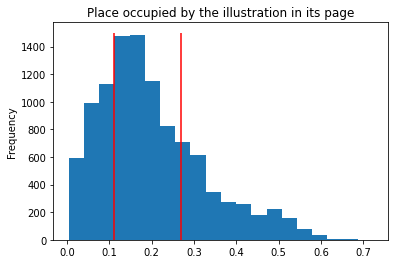

In [44]:
with open('./data/illu_ratios.json', 'r') as f:
    ratios = json.load(f)
list_ratios = list(ratios.values())
first_quartile = np.percentile(list_ratios, 25)
last_quartile = np.percentile(list_ratios, 75)
plt.hist(list_ratios, bins=20)
plt.vlines(first_quartile, 0, 1500, color='red')
plt.vlines(last_quartile, 0, 1500, color='red')
plt.gca().set(title='Place occupied by the illustration in its page', ylabel='Frequency');

We decide that the 25% smallest will be "small" and the 25% largest will be "large"

In [45]:
def size_category(ratio_size):
    return "Small Illustration" if ratio_size < first_quartile else "Large Illustration" if ratio_size > last_quartile else "Medium Illustration"

In [ ]:
df["keywords"] = df.apply(lambda row: row["keywords"] + ", " + size_category(ratios[row["id"] + ".jpg"]), axis=1)

We save the final dataframe

In [46]:
df.to_csv("data/complete_dfkv_vikus.csv", index=False)

And do not forget to create the timeline as well

In [38]:
# Create timeline
pd.DataFrame(columns=["year", "titel", "text"]).to_csv("./data/timeline.csv")

In [3]:
pd.read_csv("data/complete_dfkv_vikus.csv")

,id,_description,_artist,_source,_material,_dimensions,_journal-id,_date-artwork,year,keywords,_link-dfkv,_iiif-link,_journal-name,_link-dfkv-md,_link-iiif-md
0,ILLU_10332_143_0,Girl and Cat,Auguste Renoir,NaN,oil on canvas,NaN,1438,1882.0,1910,Reproduction,https://dfkv.dfkg.org/ng/index.html#/records/1...,https://digi.ub.uni-heidelberg.de/diglit/kk191...,Kunst und Künstler,[HERE](https://dfkv.dfkg.org/ng/index.html#/re...,[HERE](https://digi.ub.uni-heidelberg.de/digli...
1,ILLU_10346_257_0,The death of Laras,Eugène Delacroix,NaN,oil on canvas,62.00x50.00cm,1438,1858.0,1912,Reproduction,https://dfkv.dfkg.org/ng/index.html#/records/1...,https://digi.ub.uni-heidelberg.de/diglit/kk191...,Kunst und Künstler,[HERE](https://dfkv.dfkg.org/ng/index.html#/re...,[HERE](https://digi.ub.uni-heidelberg.de/digli...
2,ILLU_10359_147_0,Une Baignade à Asnières,Georges Seurat,https://www.nationalgallery.org.uk/paintings/g...,oil on canvas,201.00x300.00cm,1368,1884.0,1932,Reproduction,https://dfkv.dfkg.org/ng/index.html#/records/1...,https://digi.ub.uni-heidelberg.de/diglit/kfa19...,Die Kunst für Alle,[HERE](https://dfkv.dfkg.org/ng/index.html#/re...,[HERE](https://digi.ub.uni-heidelberg.de/digli...
3,ILLU_10362_309_0,Landscape,André Derain,NaN,oil on canvas,60.00x73.00cm,1368,1930.0,1932,Reproduction,https://dfkv.dfkg.org/ng/index.html#/records/1...,https://digi.ub.uni-heidelberg.de/diglit/kfa19...,Die Kunst für Alle,[HERE](https://dfkv.dfkg.org/ng/index.html#/re...,[HERE](https://digi.ub.uni-heidelberg.de/digli...
4,ILLU_10365_17_0,Figure at the Rideau Releve,Henri Matisse,NaN,oil on canvas,NaN,1368,1923.0,1929,Reproduction,https://dfkv.dfkg.org/ng/index.html#/records/1...,https://digi.ub.uni-heidelberg.de/diglit/kfa19...,Die Kunst für Alle,[HERE](https://dfkv.dfkg.org/ng/index.html#/re...,[HERE](https://digi.ub.uni-heidelberg.de/digli...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10369,ILLU_10558_110_0,NaN,NaN,NaN,NaN,NaN,1368,NaN,1910,Reproduction,https://dfkv.dfkg.org/ng/index.html#/records/1...,https://digi.ub.uni-heidelberg.de/diglit/kfa19...,Die Kunst für Alle,[HERE](https://dfkv.dfkg.org/ng/index.html#/re...,[HERE](https://digi.ub.uni-heidelberg.de/digli...
10370,ILLU_10575_169129_0,NaN,NaN,NaN,NaN,NaN,1569,NaN,1896,Reproduction,https://dfkv.dfkg.org/ng/index.html#/records/1...,https://digi.ub.uni-heidelberg.de/diglit/pan18...,Pan,[HERE](https://dfkv.dfkg.org/ng/index.html#/re...,[HERE](https://digi.ub.uni-heidelberg.de/digli...
10371,ILLU_11353_257_3,NaN,NaN,NaN,NaN,NaN,1336,NaN,1925,Reproduction,https://dfkv.dfkg.org/ng/index.html#/records/1...,https://digi.ub.uni-heidelberg.de/diglit/cicer...,Der Cicerone,[HERE](https://dfkv.dfkg.org/ng/index.html#/re...,[HERE](https://digi.ub.uni-heidelberg.de/digli...
10372,ILLU_14941_159_0,NaN,NaN,NaN,NaN,NaN,1484,NaN,1927,Reproduction,https://dfkv.dfkg.org/ng/index.html#/records/1...,https://gallica.bnf.fr/ark:/12148/bpt6k3054836...,L'Art vivant,[HERE](https://dfkv.dfkg.org/ng/index.html#/re...,[HERE](https://gallica.bnf.fr/ark:/12148/bpt6k...
